# Generates the plots in the "understanding algorithms" experiments

In [1]:
# import things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tol_colors as tc
import torch
import torchvision

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader
from torchvision import transforms
from weighted_exemplars import *


schemes = tc.tol_cset()
print(schemes)
cset = tc.tol_cset('high-contrast')
colors = list(cset)


('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')


# Load the data and convert it to numpy

In [2]:
trainset = torchvision.datasets.USPS(root = "./data", train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.USPS(root = "./data", train = False, download = True, transform = transforms.ToTensor())

train_loader = DataLoader(trainset, batch_size=len(trainset))
test_loader = DataLoader(testset, batch_size=len(testset))

train_X, train_y = next(iter(train_loader))

train_X_np = train_X.numpy()
train_y_np = train_y.numpy()

test_X, test_y = next(iter(test_loader))

test_X_np = test_X.numpy()
test_y_np = test_y.numpy()

In [3]:
# reshape
train_X_np = np.reshape(train_X_np, [7291, 16*16])
test_X_np = np.reshape(test_X_np, [2007, 16*16])

# We are going to split train_X_np into data set a, data set b.

## The dependent coreset will be constructed for the two datasets, using candidates from data set b and test_y_np


In [4]:
def generate_split(labels, probs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    inds_a = np.array([]).astype(int)
    inds_b = np.array([]).astype(int)
    for i in range(len(probs)):
        data_inds = np.argwhere(labels == i).flatten()
        num_inds = len(data_inds)
        if i % 2 == 0:
            num_a = int(np.floor(probs[i]*num_inds))
        else:
            num_a = int(np.ceil(probs[i]*num_inds))
        rp = np.random.permutation(num_inds)

        inds_a = np.append(inds_a, data_inds[rp[:num_a]])
        inds_b = np.append(inds_b, data_inds[rp[num_a:]])
    return inds_a, inds_b


def sigmoid(x):
    return 1./(1 + np.exp(-x))

tmp = np.linspace(4, -4, 10)
probs_a = sigmoid(tmp)

targets (a)


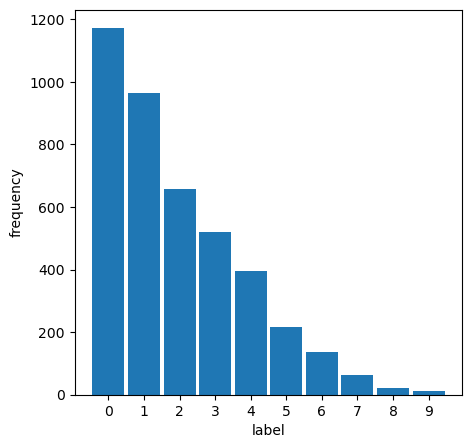

targets (b)


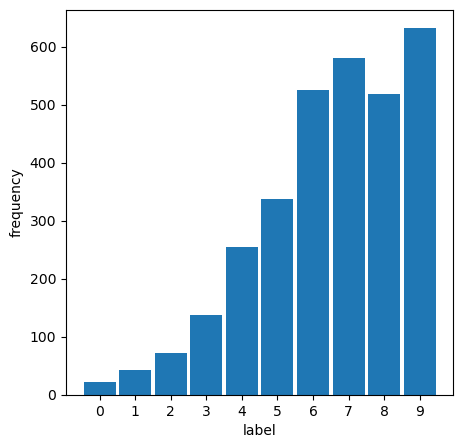

In [5]:
# split the data
train_inds_a, train_inds_b = generate_split(train_y_np, probs_a, seed=0)
#set the candidates to be the union of dataset b and the test set
candidate_inds = np.append(train_inds_b, train_X_np.shape[0] + np.arange(test_X_np.shape[0]))

print('targets (a)')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
numbers, counts = np.unique(train_y_np[train_inds_a], return_counts=True)
ax.bar(numbers, counts, width=0.9)
ax.set_xticks(np.arange(10))
ax.set_xlabel('label')
ax.set_ylabel('frequency')

plt.show()
print('targets (b)')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
numbers, counts = np.unique(train_y_np[train_inds_b], return_counts=True)
ax.bar(numbers, counts, width=0.9)
ax.set_xticks(np.arange(10))
ax.set_xlabel('label')
ax.set_ylabel('frequency')
plt.show()




# Kernel is an additive kernel, containing:

* ## overall median distance
* ## per-class median distance

for the union of a and b

In [6]:
# overall
# calculate the median of the union of Xa and Xb
test_kernel = rbf_kernel(train_X_np, gamma=1.)
unique_kernel = test_kernel[np.triu_indices(test_kernel.shape[0], k = 1)]
sigsq = -np.log(np.median(unique_kernel)) / 2.
alp = 1./(2*sigsq)

#calculate the corresponding kernel
K = rbf_kernel(np.vstack((train_X_np, test_X_np)), gamma=alp) 

# class-specific
for i in range(10):
    #calculate the median of that number
    test_kernel = rbf_kernel(train_X_np[train_y_np==i, :], gamma=1.)
    unique_kernel = test_kernel[np.triu_indices(test_kernel.shape[0], k = 1)]
    sigsq = -np.log(np.median(unique_kernel)) / 2.
    alp = 1./(2*sigsq)
    #calculate the corresponding kernel
    K += rbf_kernel(np.vstack((train_X_np, test_X_np)), gamma=alp)
    
# normalize because code assumes diagonal is 1
K = K / 11.

In [7]:
MMD_threshold = 0.005
joint_exemplars, joint_weights =  weighted_exemplars(K, 
                                                     [train_inds_a, train_inds_b],
                                                     MMD_threshold=MMD_threshold, 
                                                     candidate_indices=candidate_inds, 
                                                     relearn_weights=False, 
                                                     return_mmds = False)
    


adding exemplar 2
adding exemplar 3
adding exemplar 4
adding exemplar 5
adding exemplar 6
adding exemplar 7
adding exemplar 8
adding exemplar 9
adding exemplar 10
adding exemplar 11
adding exemplar 12
adding exemplar 13
adding exemplar 14
adding exemplar 15
adding exemplar 16
adding exemplar 17
adding exemplar 18
adding exemplar 19
adding exemplar 20
adding exemplar 21
adding exemplar 22
adding exemplar 23
adding exemplar 24
adding exemplar 25
adding exemplar 26
adding exemplar 27
adding exemplar 28
adding exemplar 29
adding exemplar 30
adding exemplar 31
adding exemplar 32
adding exemplar 33
adding exemplar 34
adding exemplar 35
adding exemplar 36
adding exemplar 37
adding exemplar 38
adding exemplar 39
adding exemplar 40
adding exemplar 41
adding exemplar 42
adding exemplar 43
adding exemplar 44
adding exemplar 45
adding exemplar 46
adding exemplar 47
adding exemplar 48
adding exemplar 49
adding exemplar 50
adding exemplar 51
adding exemplar 52
adding exemplar 53
adding exemplar 54
a

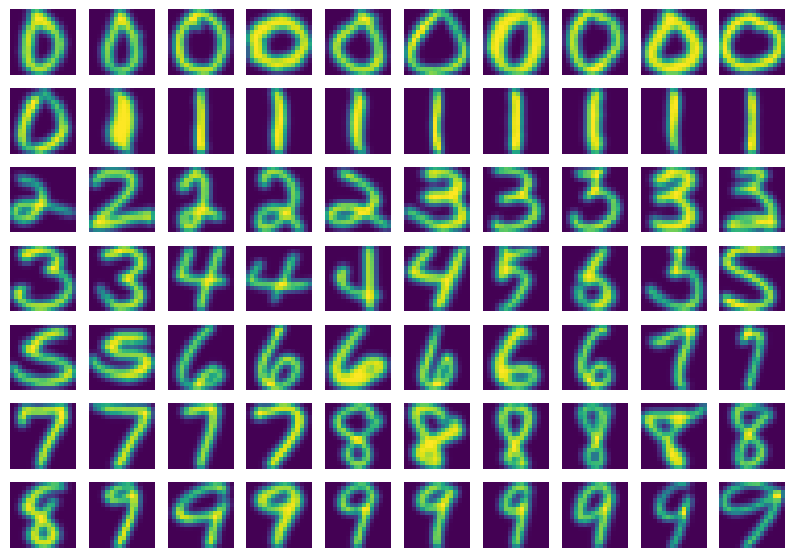

In [8]:
# visualize the exemplars

#sort by number
all_y = np.append(train_y_np, test_y_np)
all_X = np.vstack((train_X_np, test_X_np))
exemplar_order = np.argsort(all_y[joint_exemplars])
ordered_exemplars = joint_exemplars[exemplar_order]

fig, ax = plt.subplots(7, 10, figsize=(10, 7))
k=0
for i in range(7):
    for j in range(10):
        if k < len(ordered_exemplars):
            num = np.reshape(all_X[ordered_exemplars[k], :], [16, 16])
            ax[i, j].imshow(num)
        ax[i, j].axis('off')
        k += 1
plt.show()

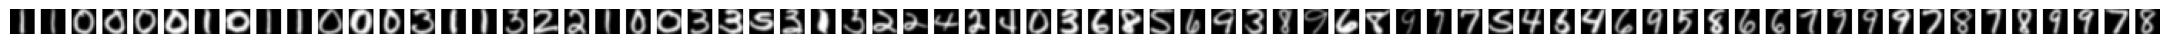

In [9]:
# sort based on relative weight in A and B
# include epsilon because there are some zero weights... 
# encourages to put 0/inf's in order of importance in their non-zero dataset
epsilon = 1e-6
weight_diff = (joint_weights[0] + epsilon)/ (joint_weights[1] + epsilon)

weight_diff_order = np.argsort(weight_diff)[::-1]


# plot images in that order (for use in plot)
num_exemplars = len(joint_exemplars)

img_width = 16
gap_width = 4
width = num_exemplars * img_width + (num_exemplars - 1)* gap_width
height=16
im = np.ones((height, width))

x_offset = 0

fig, ax = plt.subplots(1, 1, figsize= (width/50, height/50))
for i in range(num_exemplars):
    im[:, x_offset: x_offset + img_width] = np.reshape(all_X[joint_exemplars[weight_diff_order][i], :], (16, 16))
    x_offset += img_width + gap_width

ax.imshow(im, cmap='gray', vmin=0., vmax=1.)
ax.axis('off')
plt.show()

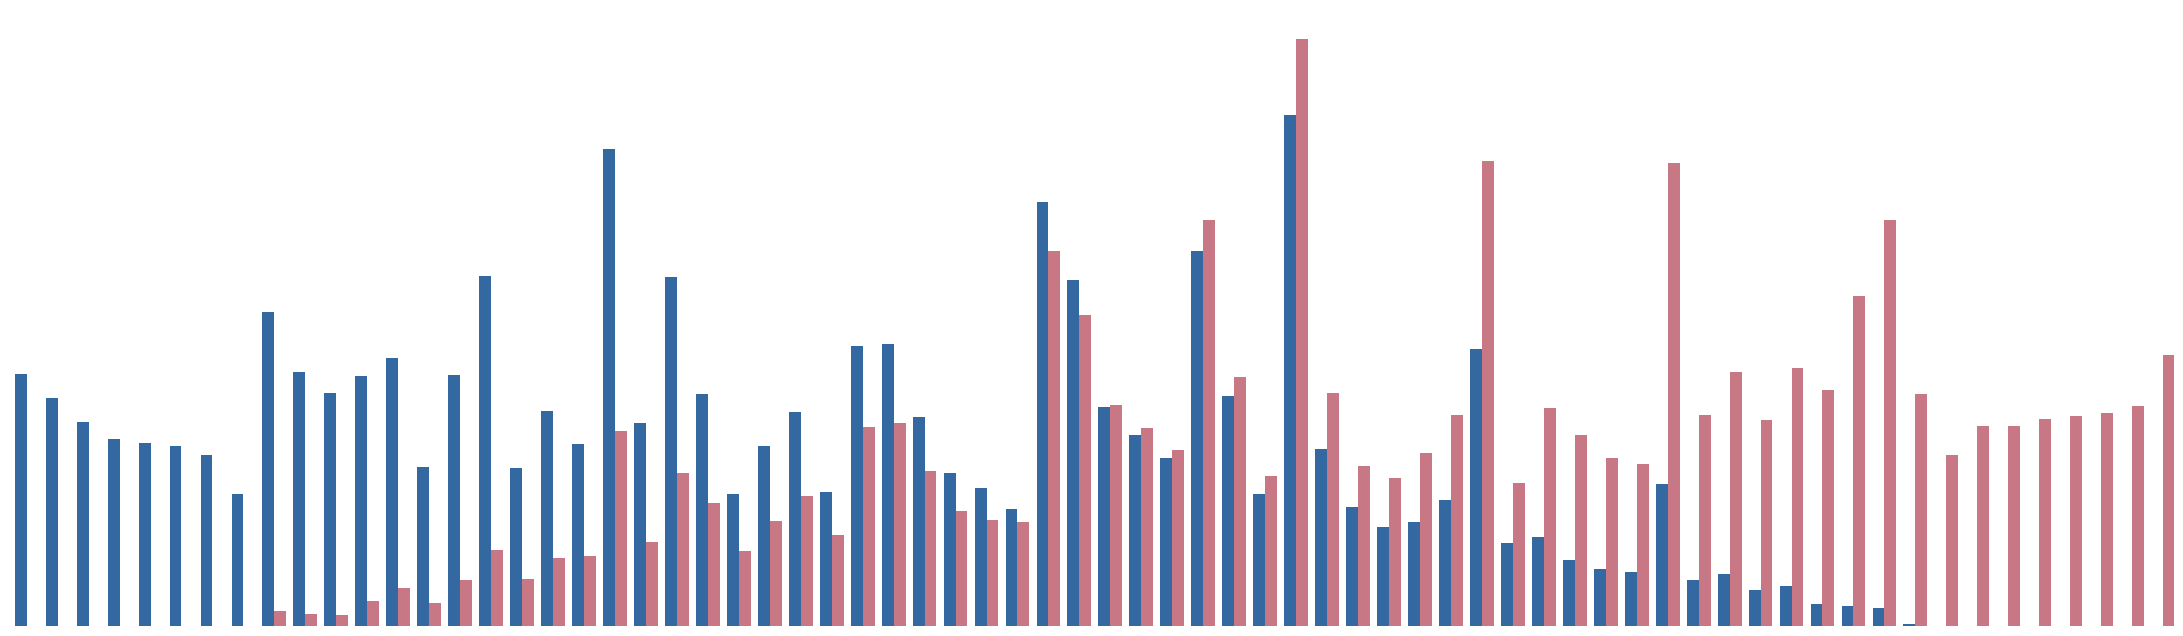

In [10]:
# generate corresponding histogram


fig, ax = plt.subplots(1, 1, figsize= (width/50, 8))
ax.bar(x=1.3*np.arange(len(weight_diff))+0.25, height=joint_weights[0][weight_diff_order], width=0.5, color=colors[0], align='center', alpha=0.8)
ax.bar(x=1.3*np.arange(len(weight_diff))+0.75, height=joint_weights[1][weight_diff_order], width=0.5, color=colors[2], align='center', alpha=0.8)
ax.set_xlim(-0.2, np.max(1.2-.25 +1.3*np.arange(len(weight_diff))))
ax.axis('off')
plt.show()

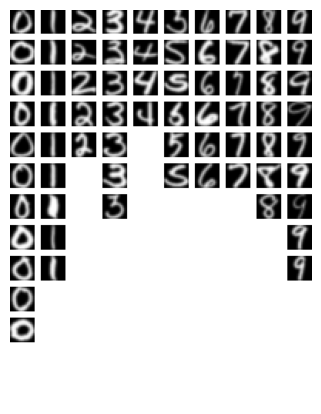

In [11]:
# figure for grouped histogram
num_exemplars = len(joint_exemplars)
max_rep = 13
img_width = 16
gap_width = 4
width = 10 * img_width + 9 * gap_width
img_height = 16
height = max_rep * img_height + (max_rep - 1) * gap_width
im = np.ones((height, width))


x_offset = np.zeros(10).astype(int)
for i in range(10):
    x_offset[i+1:] += img_width + gap_width
y_offset = np.zeros(10).astype(int)

fig, ax = plt.subplots(1, 1, figsize= (width/50, height/50))
for i in range(num_exemplars):
    number = all_y[joint_exemplars[i]]
    im[y_offset[number]: y_offset[number] + img_height, :][:, x_offset[number]: x_offset[number]+ img_width] \
        = np.reshape(all_X[joint_exemplars[i], :], (16, 16))
    
    y_offset[number] += img_height + gap_width

ax.imshow(im, cmap='gray', vmin=0., vmax=1.)
ax.axis('off')
plt.show()

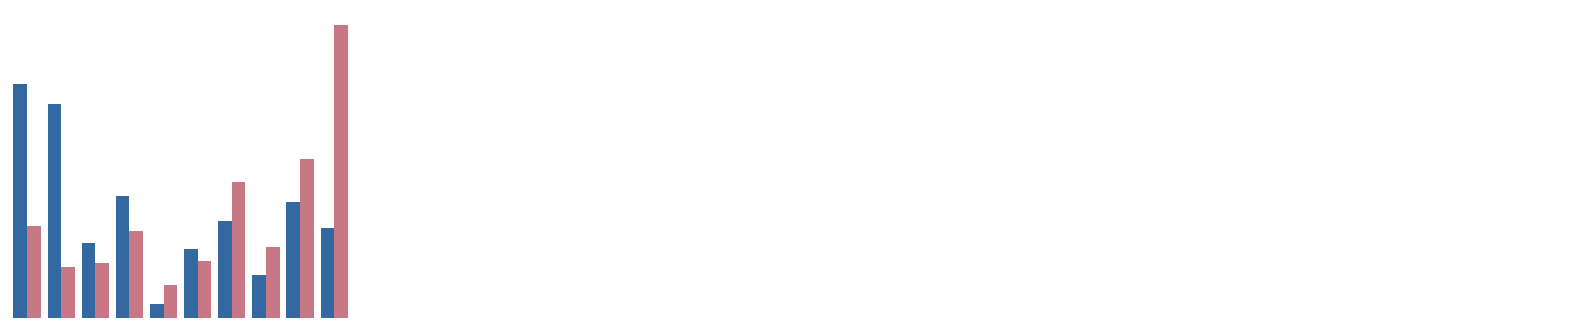

In [12]:
# corresponding histogram
cum_weights_a = np.zeros(10)
cum_weights_b = np.zeros(10)

for i in range(30):
    ind = all_y[joint_exemplars[i]]
    cum_weights_a[ind] += joint_weights[0][i]
    cum_weights_b[ind] += joint_weights[1][i]

fig, ax = plt.subplots(1, 1, figsize= (20, 4))
ax.bar(x=2*np.arange(10)+0.4, height=cum_weights_a, width=0.8, color=colors[0], align='center', alpha=0.8)
ax.bar(x=2*np.arange(10)+1.2, height=cum_weights_b, width=0.8, color=colors[2], align='center', alpha=0.8)
ax.set_xlim(-0.2, np.max(1.2-.25 +1.3*np.arange(len(weight_diff))))
ax.axis('off')
plt.show()

# Now, let's train algorithms on $X_a$

In [13]:
# note, parameters were manually modified to get similar train set performance across all algorithms
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(train_X_np[train_inds_a], train_y_np[train_inds_a])
dt_a_score = dt.score(train_X_np[train_inds_a], train_y_np[train_inds_a])
dt_b_score = dt.score(train_X_np[train_inds_b], train_y_np[train_inds_b])
print('DT score on dataset a: {}'.format(dt_a_score))
print('DT score on dataset b: {}'.format(dt_b_score))
rf = RandomForestClassifier()
rf.fit(train_X_np[train_inds_a], train_y_np[train_inds_a])
rf_a_score = rf.score(train_X_np[train_inds_a], train_y_np[train_inds_a])
rf_b_score = rf.score(train_X_np[train_inds_b], train_y_np[train_inds_b])
print('RF score on dataset a: {}'.format(rf_a_score))
print('RF score on dataset b: {}'.format(rf_b_score))
mlp = MLPClassifier()
mlp.fit(train_X_np[train_inds_a], train_y_np[train_inds_a])
mlp_a_score = mlp.score(train_X_np[train_inds_a], train_y_np[train_inds_a])
mlp_b_score = mlp.score(train_X_np[train_inds_b], train_y_np[train_inds_b])
print('MLP score on dataset a: {}'.format(mlp_a_score))
print('MLP score on dataset b: {}'.format(mlp_b_score))

DT score on dataset a: 0.9584833213342933
DT score on dataset b: 0.5771446862996159
RF score on dataset a: 1.0
RF score on dataset b: 0.7298335467349552
MLP score on dataset a: 0.9997600191984641
MLP score on dataset b: 0.8386683738796414


Confusion of DT on a


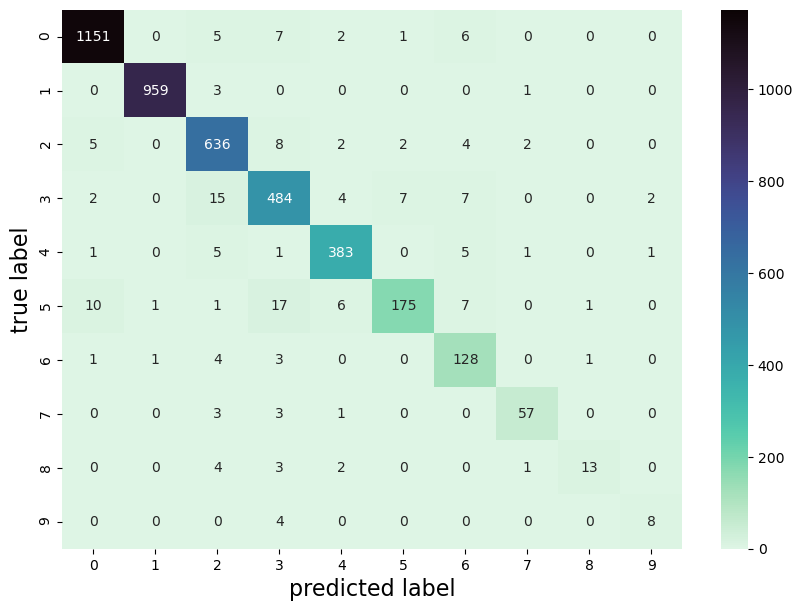

Confusion of DT on b


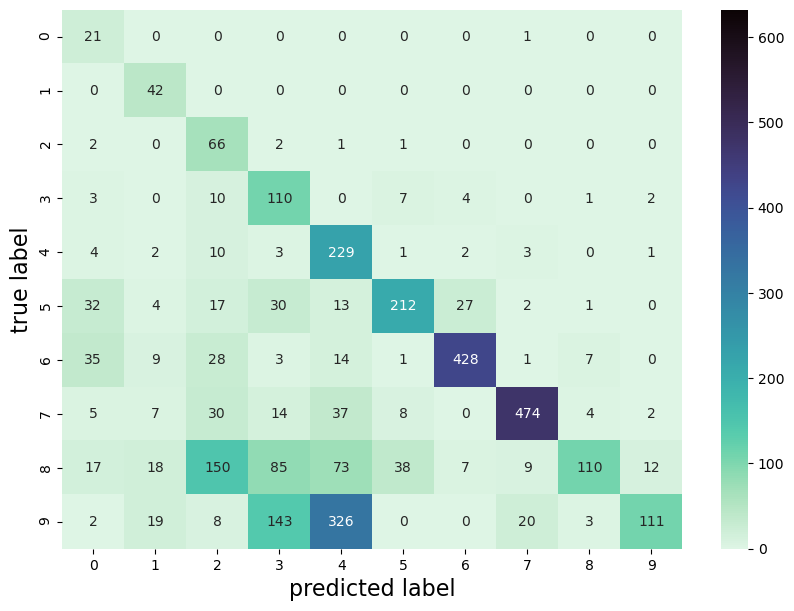

In [14]:
y_a =train_y_np[train_inds_a]
y_b =train_y_np[train_inds_b]
print('Confusion of DT on a')
dt_confusion_a = confusion_matrix(y_a, dt.predict(train_X_np[train_inds_a]))
df_cm = pd.DataFrame(dt_confusion_a, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=1172)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

print('Confusion of DT on b')
dt_confusion_b = confusion_matrix(y_b, dt.predict(train_X_np[train_inds_b]))
df_cm = pd.DataFrame(dt_confusion_b, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=632)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

Confusion of RF on a


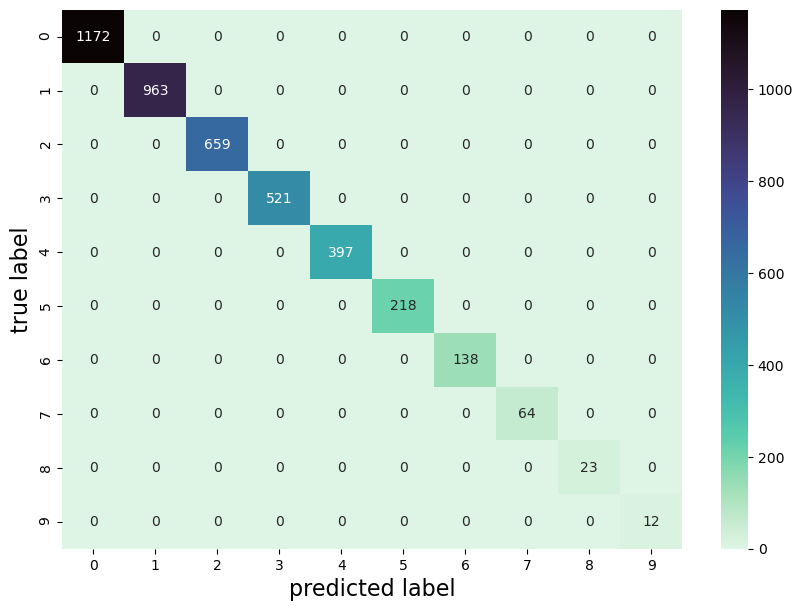

Confusion of RF on b


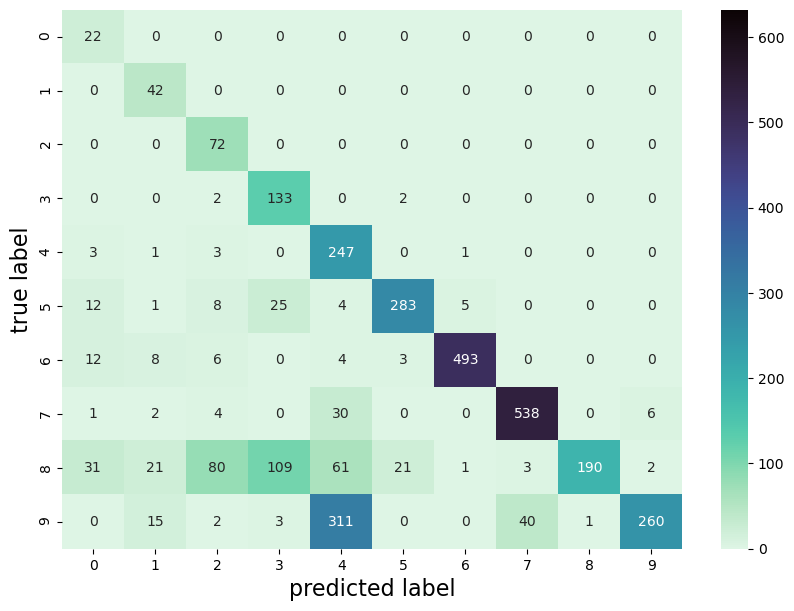

In [15]:
print('Confusion of RF on a')
rf_confusion_a = confusion_matrix(y_a, rf.predict(train_X_np[train_inds_a]))
df_cm = pd.DataFrame(rf_confusion_a, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=1172)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

print('Confusion of RF on b')
rf_confusion_b = confusion_matrix(y_b, rf.predict(train_X_np[train_inds_b]))
df_cm = pd.DataFrame(rf_confusion_b, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=632)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

Confusion of MLP on a


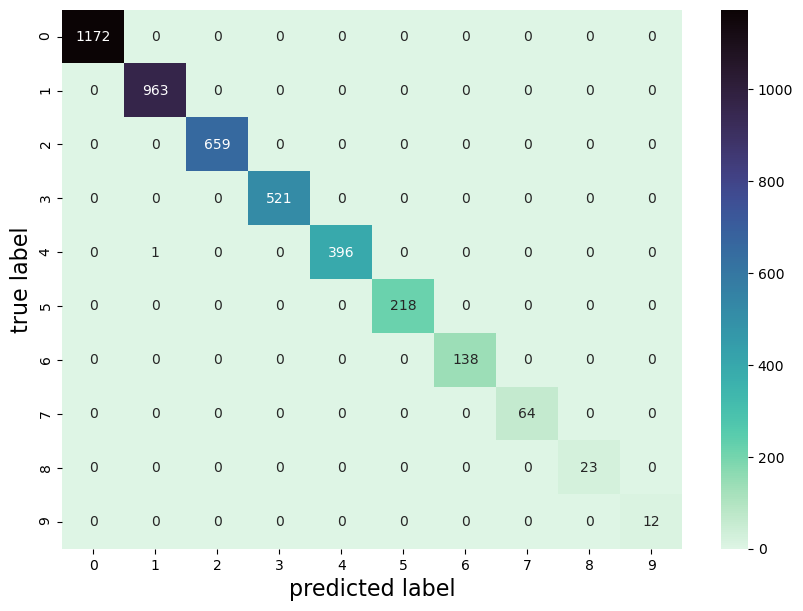

Confusion of MLP on b


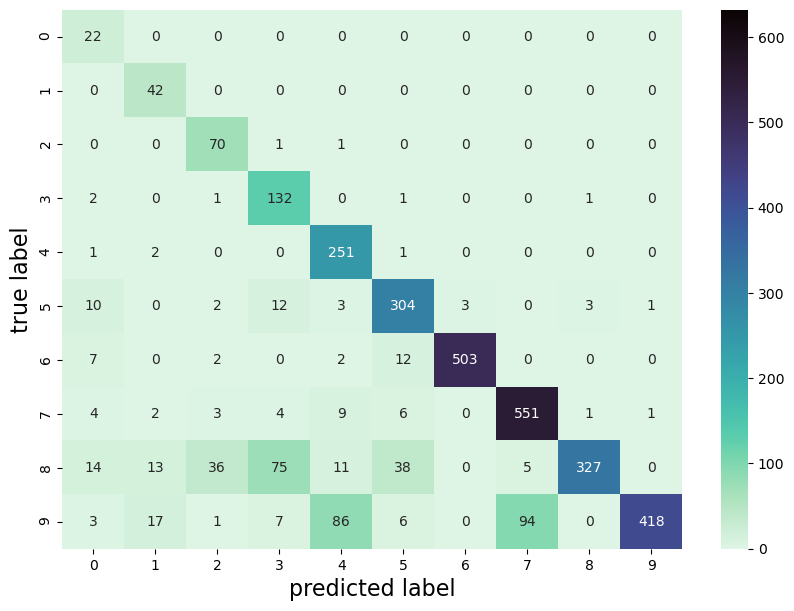

In [16]:
print('Confusion of MLP on a')
mlp_confusion_a = confusion_matrix(y_a, mlp.predict(train_X_np[train_inds_a]))
df_cm = pd.DataFrame(mlp_confusion_a, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=1172)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

print('Confusion of MLP on b')
mlp_confusion_b = confusion_matrix(y_b, mlp.predict(train_X_np[train_inds_b]))
df_cm = pd.DataFrame(mlp_confusion_b, index = np.arange(10),
                  columns = np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g', cmap='mako_r', vmin=0, vmax=632)
plt.xlabel('predicted label', fontsize=16)
plt.ylabel('true label', fontsize=16)
plt.show()

images over-represented in b


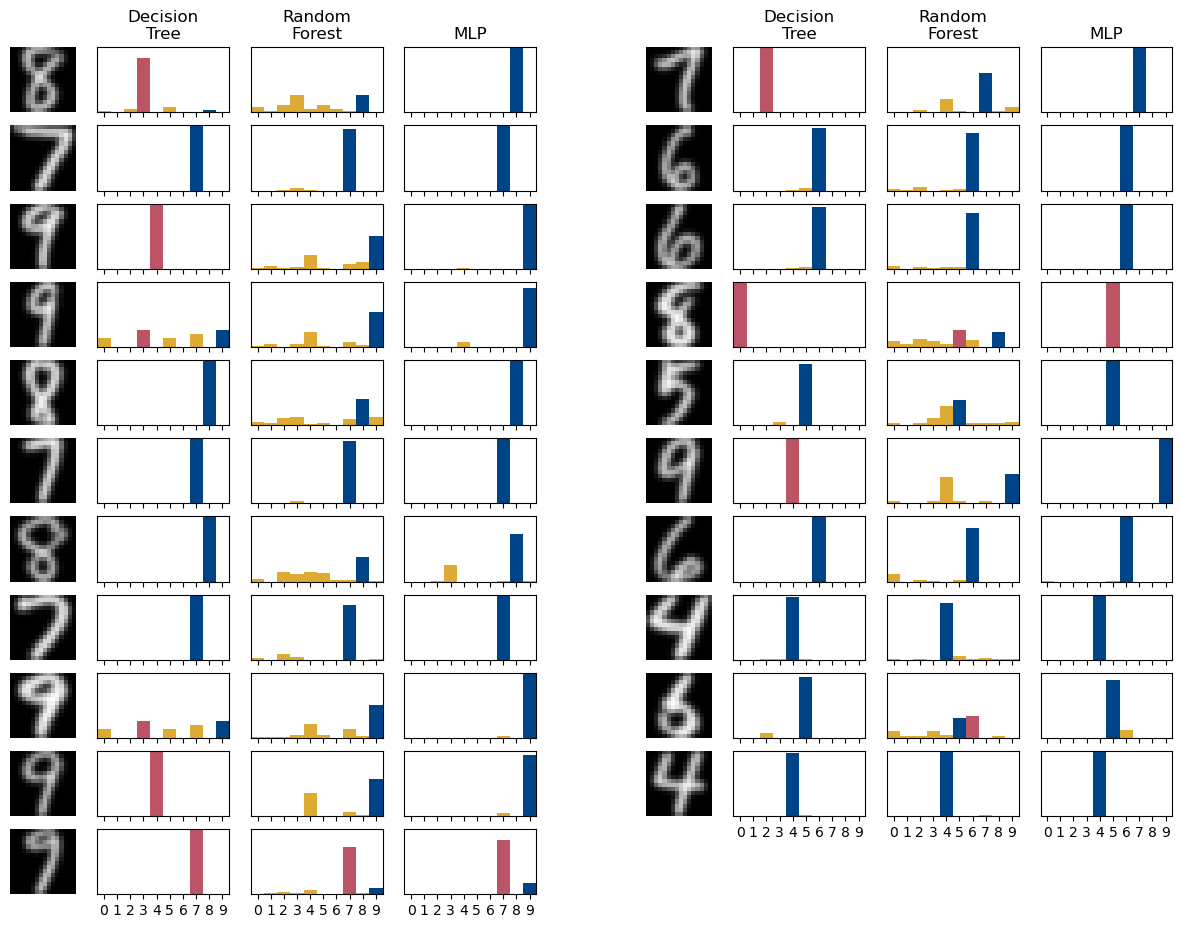

In [17]:


print('images over-represented in b')
model_list = [dt, rf, mlp]
epsilon = 1e-6
weight_diff = (joint_weights[1] + epsilon)/ (joint_weights[0] + epsilon)

weight_diff_order = np.argsort(weight_diff)[::-1]

pred_probs = []
for model in model_list:
    pred_probs.append(model.predict_proba(all_X[joint_exemplars[weight_diff_order]]))


num_greater = np.sum(weight_diff > 2)
fig, ax = plt.subplots(11, 9, gridspec_kw={'width_ratios': [1, 2, 2, 2, 1, 1, 2, 2, 2]}, 
                       figsize=(15, 11))
for  i in range(num_greater):
    iplus = 0
    jplus = 0
    if i > 10:
        iplus=-11
        jplus=5
    number_val = all_y[joint_exemplars[weight_diff_order[i]]]
    ax[i+iplus, jplus].imshow(np.reshape(all_X[joint_exemplars[weight_diff_order[i]]], (16, 16)), cmap='gray', vmin=0., vmax=1.)
    ax[i+iplus, jplus].axis('off')
    ax[i+iplus, 4].axis('off')
    for j in range(len(model_list)):
        max_prob_val = np.argmax(pred_probs[j][i, :])
        wrong_inds = np.setdiff1d(np.arange(10), np.array([number_val, max_prob_val]))
        ax[i+iplus, j+1+jplus].bar(wrong_inds, pred_probs[j][i, wrong_inds], width=1., color=colors[1])
        ax[i+iplus, j+1+jplus].bar([max_prob_val], [pred_probs[j][i, max_prob_val]], color=colors[2], width=1.)
        ax[i+iplus, j+1+jplus].bar([number_val], [pred_probs[j][i, number_val]], color=colors[0], width=1.)
        ax[i+iplus, j+1+jplus].set_ylim(0, 1)
        ax[i+iplus, j+1+jplus].set(yticklabels=[])  # remove the tick labels
        ax[i+iplus, j+1+jplus].tick_params(left=False)
        #line = ax[i, j+1].get_lines()
        #xd = line[0].get_xdata()
        #yd = line[0].get_ydata()
        #plt.setp(stemlines[0], 'color', 'red')
        ax[i+iplus, j+1+jplus].set_xticks(np.arange(10))
        ax[i+iplus, j+1+jplus].set_xlim(-0.5, 9.5)
        if not ((i==10) or (i==20)):
            ax[i+iplus, j+1+jplus].set(xticklabels=[])
ax[10, 4].axis('off')
ax[10, 5].axis('off')
ax[10, 6].axis('off')
ax[10, 7].axis('off')
ax[10, 8].axis('off')
ax[0, 1].set_title('Decision\nTree')
ax[0, 2].set_title('Random\nForest')
ax[0, 3].set_title('MLP')
ax[0, 6].set_title('Decision\nTree')
ax[0, 7].set_title('Random\nForest')
ax[0, 8].set_title('MLP')
plt.show()

images over-represented in a


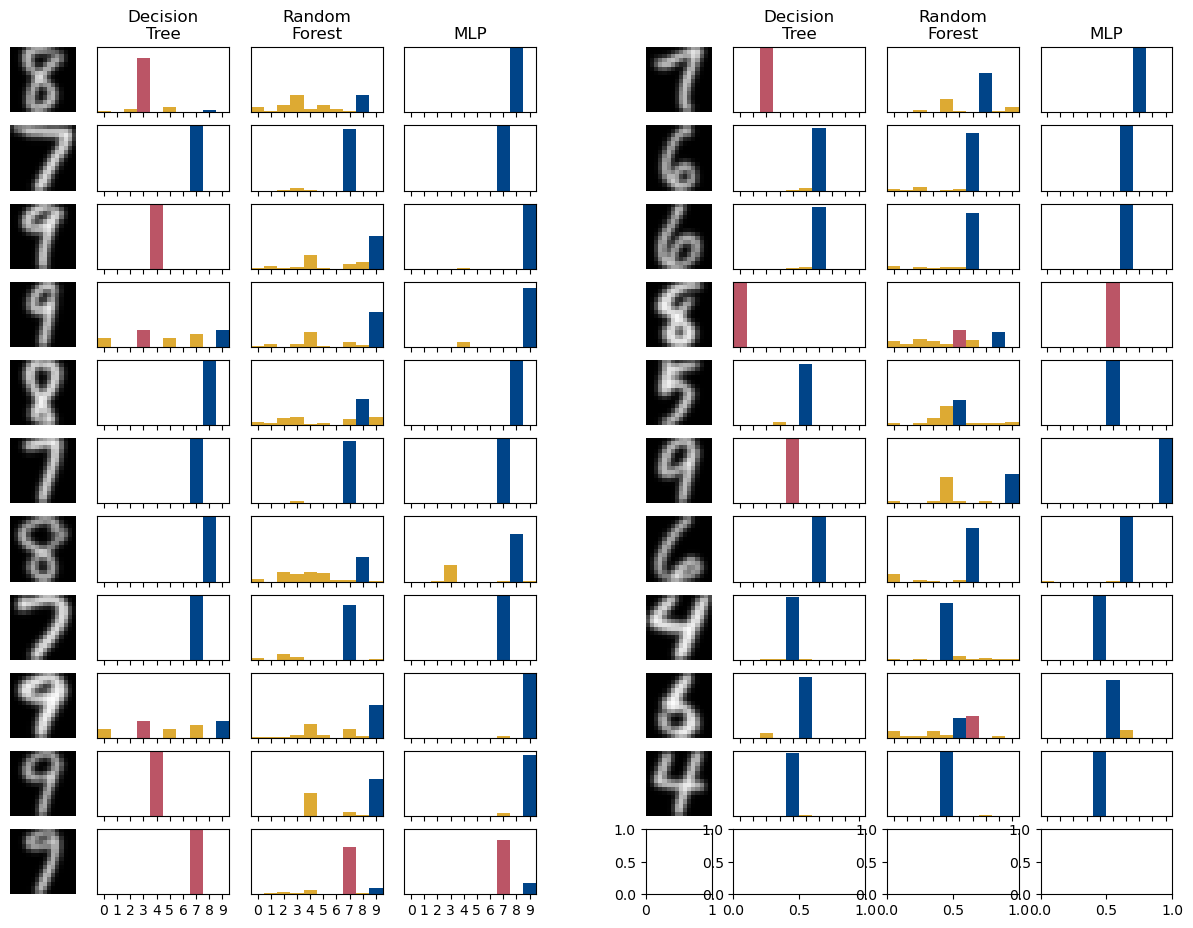

In [18]:
print('images over-represented in a')
model_list = [dt, rf, mlp]


weight_diff_order = np.argsort(weight_diff)[::-1]

pred_probs = []
for model in model_list:
    pred_probs.append(model.predict_proba(all_X[joint_exemplars[weight_diff_order]]))


num_greater = np.sum(weight_diff > 2) # 20

fig, ax = plt.subplots(11, 9, gridspec_kw={'width_ratios': [1, 2, 2, 2, 1, 1, 2, 2, 2]}, 
                       figsize=(15, 11))
for  i in range(num_greater):
    iplus = 0
    jplus = 0
    if i > 10:
        iplus=-11
        jplus=5
    number_val = all_y[joint_exemplars[weight_diff_order[i]]]
    ax[i+iplus, jplus].imshow(np.reshape(all_X[joint_exemplars[weight_diff_order[i]]], (16, 16)), cmap='gray', vmin=0., vmax=1.)
    ax[i+iplus, jplus].axis('off')
    ax[i+iplus, 4].axis('off')
    for j in range(len(model_list)):
        max_prob_val = np.argmax(pred_probs[j][i, :])
        wrong_inds = np.setdiff1d(np.arange(10), np.array([number_val, max_prob_val]))
        ax[i+iplus, j+1+jplus].bar(wrong_inds, pred_probs[j][i, wrong_inds], width=1., color=colors[1])
        ax[i+iplus, j+1+jplus].bar([max_prob_val], [pred_probs[j][i, max_prob_val]], color=colors[2], width=1.)
        ax[i+iplus, j+1+jplus].bar([number_val], [pred_probs[j][i, number_val]], color=colors[0], width=1.)
        ax[i+iplus, j+1+jplus].set_ylim(0, 1)
        ax[i+iplus, j+1+jplus].set(yticklabels=[])  # remove the tick labels
        ax[i+iplus, j+1+jplus].tick_params(left=False)
        #line = ax[i, j+1].get_lines()
        #xd = line[0].get_xdata()
        #yd = line[0].get_ydata()
        #plt.setp(stemlines[0], 'color', 'red')
        ax[i+iplus, j+1+jplus].set_xticks(np.arange(10))
        ax[i+iplus, j+1+jplus].set_xlim(-0.5, 9.5)
        if not ((i==10) or (i==21)):
            ax[i+iplus, j+1+jplus].set(xticklabels=[])

ax[0, 1].set_title('Decision\nTree')
ax[0, 2].set_title('Random\nForest')
ax[0, 3].set_title('MLP')
ax[0, 6].set_title('Decision\nTree')
ax[0, 7].set_title('Random\nForest')
ax[0, 8].set_title('MLP')
plt.show()



# Get critics



In [19]:

critics_a = select_criticism_regularized(K, train_inds_a, joint_exemplars, joint_weights[0], 20, reg='logdet')

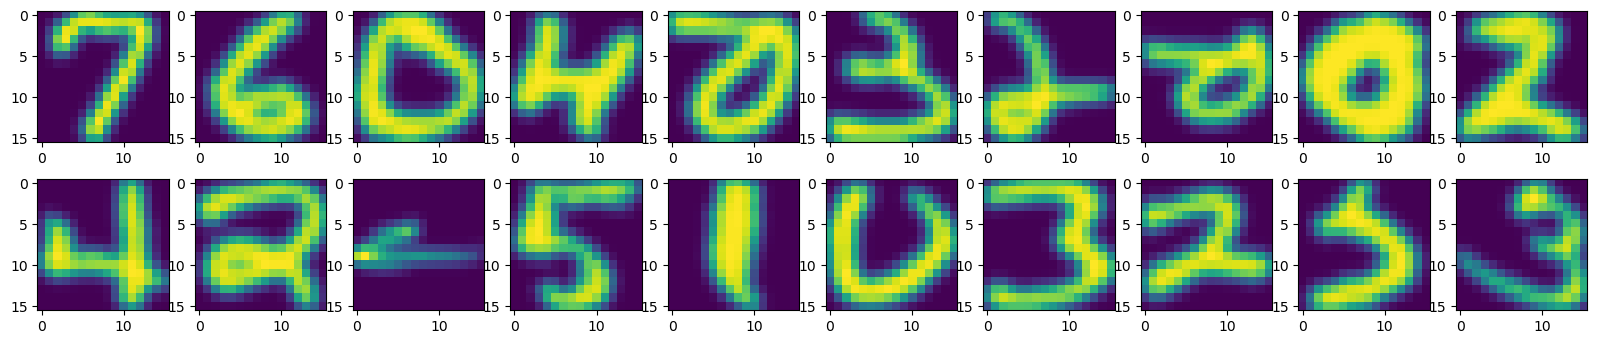

In [20]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    ax[0, i].imshow(np.reshape(all_X[critics_a[i]], (16, 16)))
for i in range(10, 20):
    ax[1, i-10].imshow(np.reshape(all_X[critics_a[i]], (16, 16)))
plt.show()

In [21]:
critics_b = select_criticism_regularized(K, train_inds_b, joint_exemplars, joint_weights[0], 20, reg='logdet')

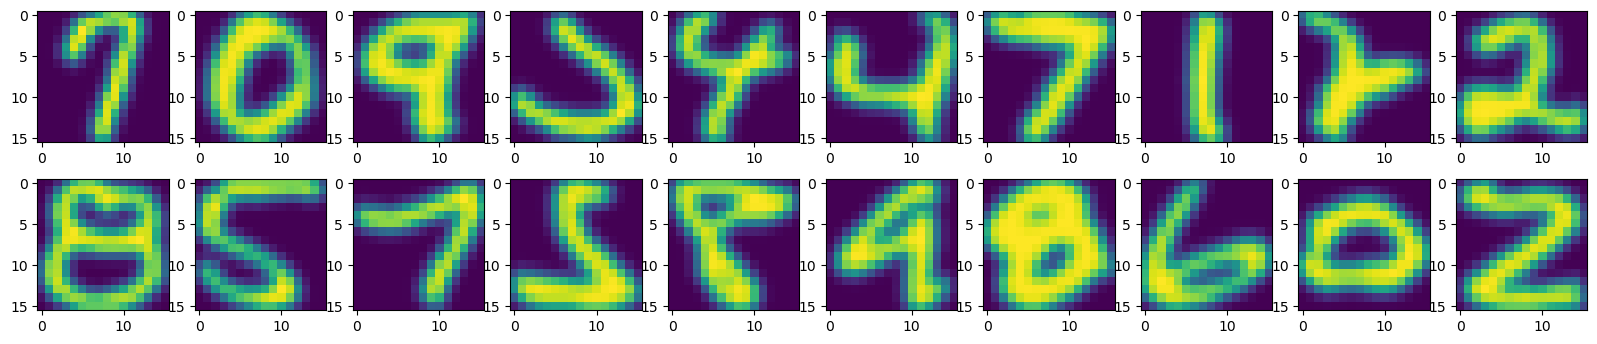

In [22]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    ax[0, i].imshow(np.reshape(all_X[critics_b[i]], (16, 16)))
for i in range(10, 20):
    ax[1, i-10].imshow(np.reshape(all_X[critics_b[i]], (16, 16)))
plt.show()

criticisms for a


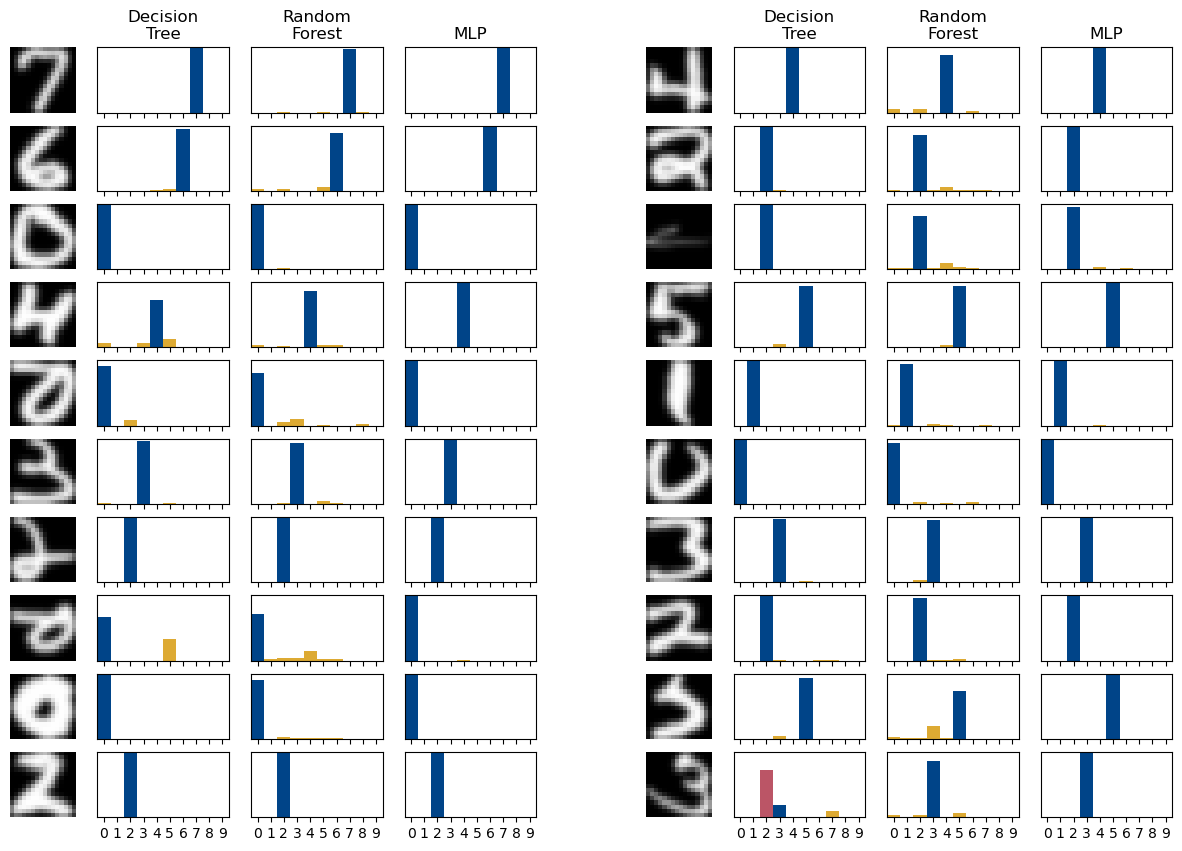

In [23]:


print('criticisms for a')
model_list = [dt, rf, mlp]

pred_probs = []
for model in model_list:
    pred_probs.append(model.predict_proba(all_X[critics_a]))



fig, ax = plt.subplots(10, 9, gridspec_kw={'width_ratios': [1, 2, 2, 2, 1, 1, 2, 2, 2]}, 
                       figsize=(15, 10))
for  i in range(20):
    iplus = 0
    jplus = 0
    if i > 9:
        iplus=-10
        jplus=5
    number_val = all_y[critics_a[i]]
    ax[i+iplus, jplus].imshow(np.reshape(all_X[critics_a[i]], (16, 16)), cmap='gray', vmin=0., vmax=1.)
    ax[i+iplus, jplus].axis('off')
    ax[i+iplus, 4].axis('off')
    for j in range(len(model_list)):
        max_prob_val = np.argmax(pred_probs[j][i, :])
        wrong_inds = np.setdiff1d(np.arange(10), np.array([number_val, max_prob_val]))
        ax[i+iplus, j+1+jplus].bar(wrong_inds, pred_probs[j][i, wrong_inds], width=1., color=colors[1])
        ax[i+iplus, j+1+jplus].bar([max_prob_val], [pred_probs[j][i, max_prob_val]], color=colors[2], width=1.)
        ax[i+iplus, j+1+jplus].bar([number_val], [pred_probs[j][i, number_val]], color=colors[0], width=1.)
        ax[i+iplus, j+1+jplus].set_ylim(0, 1)
        ax[i+iplus, j+1+jplus].set(yticklabels=[])  # remove the tick labels
        ax[i+iplus, j+1+jplus].tick_params(left=False)
        ax[i+iplus, j+1+jplus].set_xticks(np.arange(10))
        ax[i+iplus, j+1+jplus].set_xlim(-0.5, 9.5)
        if not ((i==9) or (i==19)):
            ax[i+iplus, j+1+jplus].set(xticklabels=[])
        #line = ax[i, j+1].get_lines()
        #xd = line[0].get_xdata()
        #yd = line[0].get_ydata()
        #plt.setp(stemlines[0], 'color', 'red')
ax[0, 1].set_title('Decision\nTree')
ax[0, 2].set_title('Random\nForest')
ax[0, 3].set_title('MLP')
ax[0, 6].set_title('Decision\nTree')
ax[0, 7].set_title('Random\nForest')
ax[0, 8].set_title('MLP')
plt.show()

criticisms for b


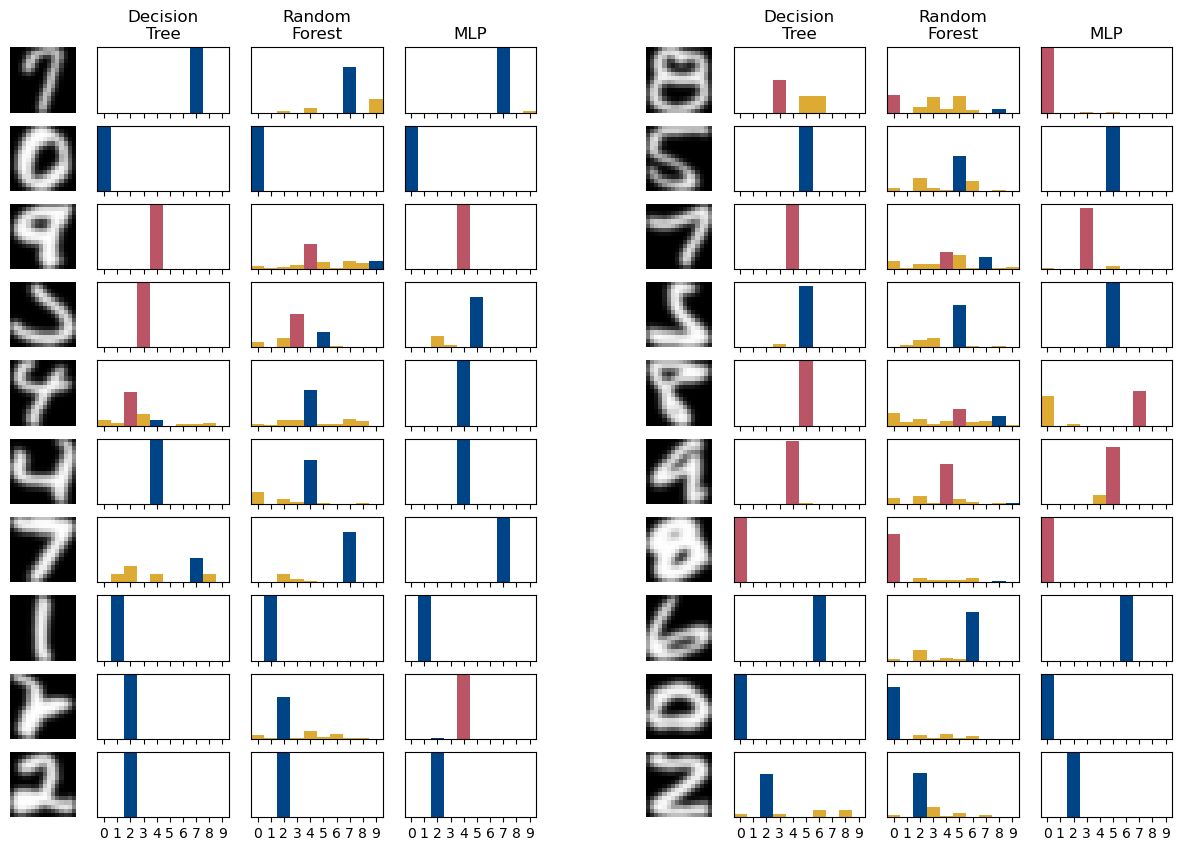

In [24]:
print('criticisms for b')
model_list = [dt, rf, mlp]

pred_probs = []
for model in model_list:
    pred_probs.append(model.predict_proba(all_X[critics_b]))
fig, ax = plt.subplots(10, 9, gridspec_kw={'width_ratios': [1, 2, 2, 2, 1, 1, 2, 2, 2]}, 
                       figsize=(15, 10))
for  i in range(20):
    iplus = 0
    jplus = 0
    if i > 9:
        iplus=-10
        jplus=5
    number_val = all_y[critics_b[i]]
    ax[i+iplus, jplus].imshow(np.reshape(all_X[critics_b[i]], (16, 16)), cmap='gray', vmin=0., vmax=1.)
    ax[i+iplus, jplus].axis('off')
    ax[i+iplus, 4].axis('off')
    for j in range(len(model_list)):
        max_prob_val = np.argmax(pred_probs[j][i, :])
        wrong_inds = np.setdiff1d(np.arange(10), np.array([number_val, max_prob_val]))
        ax[i+iplus, j+1+jplus].bar(wrong_inds, pred_probs[j][i, wrong_inds], width=1., color=colors[1])
        ax[i+iplus, j+1+jplus].bar([max_prob_val], [pred_probs[j][i, max_prob_val]], color=colors[2], width=1.)
        ax[i+iplus, j+1+jplus].bar([number_val], [pred_probs[j][i, number_val]], color=colors[0], width=1.)
        ax[i+iplus, j+1+jplus].set_ylim(0, 1)
        ax[i+iplus, j+1+jplus].set(yticklabels=[])  # remove the tick labels
        ax[i+iplus, j+1+jplus].tick_params(left=False)
        ax[i+iplus, j+1+jplus].set_xticks(np.arange(10))
        ax[i+iplus, j+1+jplus].set_xlim(-0.5, 9.5)
        if not ((i==9) or (i==19)):
            ax[i+iplus, j+1+jplus].set(xticklabels=[])
        #line = ax[i, j+1].get_lines()
        #xd = line[0].get_xdata()
        #yd = line[0].get_ydata()
        #plt.setp(stemlines[0], 'color', 'red')
ax[0, 1].set_title('Decision\nTree')
ax[0, 2].set_title('Random\nForest')
ax[0, 3].set_title('MLP')
ax[0, 6].set_title('Decision\nTree')
ax[0, 7].set_title('Random\nForest')
ax[0, 8].set_title('MLP')
plt.show()